In [1]:
from IPython.display import FileLink
from sconce.datasets import CsvImageFolder, Subset
from sconce.data_feeds import ImageFeed
from sconce.models.base import Model
from sconce.models.layers import AdaptiveAveragePooling2dLayer, Convolution2dLayer
from sconce.parameter_group import ParameterGroup
from sconce.schedules import Cosine
from sconce.trainer import Trainer
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.models import resnet34

import numpy as np
import os
import sconce
import torch

print(f"Notebook was run with pytorch-sconce version: {sconce.__version__}")

Notebook was run with pytorch-sconce version: 1.2.3


## Load images and split them into a `training_feed` and a `validation_feed`

To get data feeds suitable to train our model, we'll follow the following steps:

    l. Define transforms
    2. Create a dataset from the .tsv file
    3. Split that dataset into a training dataset and a validation dataset
    4. Create a feeds from the datasets

In [2]:
class RegressionCsvImageFolder(CsvImageFolder):
    # We make this class because the CsvImageFolder dataset returns
    # class index as the target instead of the actual class's value
    def __getitem__(self, index):
        i, t = super().__getitem__(index)
        classes = np.array(self.classes, dtype=np.float32)
        t = np.log1p(classes[int(t)])
        return i, t
    
def get_data_feeds(image_size, batch_size, split_ratio=0.8):
    training_transform = transforms.Compose([
        transforms.Resize(int(image_size*1.10)),
        transforms.RandomAffine(degrees=(0,5), translate=(0.02, 0.08), scale=(1.0, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0], std=[1.0])
    ])

    validation_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0], std=[1.0])
    ])

    dataset_kwargs = dict(root='data', 
                          csv_path='metadata/data.tsv',
                          csv_delimiter='\t',
                          filename_key='filename',
                          classes_key='value',
                          target_transform=torch.Tensor)
    
    full_dataset = RegressionCsvImageFolder(**dataset_kwargs)
    print("Found %s images." % len(full_dataset))
    
    num_samples = len(full_dataset)
    indices = np.arange(0, num_samples)
    np.random.shuffle(indices)
    
    training_indices   = indices[:int(num_samples * split_ratio)]
    validation_indices = indices[int(num_samples * split_ratio):]
    
    training_dataset = Subset(dataset=RegressionCsvImageFolder(transform=training_transform, **dataset_kwargs),
                              indices=training_indices)
    validation_dataset = Subset(dataset=RegressionCsvImageFolder(transform=validation_transform, **dataset_kwargs),
                              indices=validation_indices)

    feed_kwargs = dict(batch_size=batch_size, num_workers=7, shuffle=True)
    training_feed   = ImageFeed.from_dataset(training_dataset, **feed_kwargs)
    validation_feed = ImageFeed.from_dataset(validation_dataset, **feed_kwargs)
    
    return training_feed, validation_feed

In [3]:
training_feed, validation_feed = get_data_feeds(image_size=224, batch_size=60)

Found 4387 images.


In [4]:
inputs, targets = training_feed.next()
inputs.shape, targets.shape

(torch.Size([60, 3, 224, 224]), torch.Size([60]))

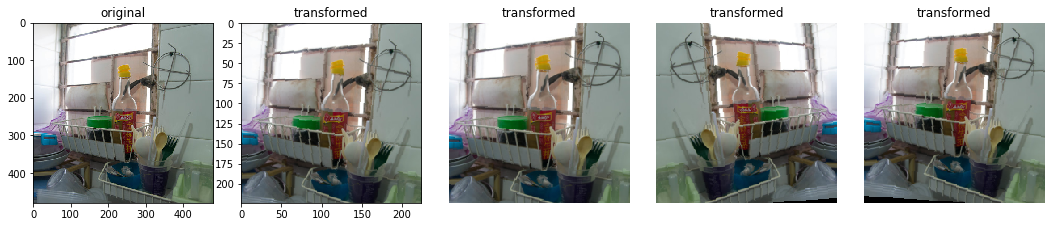

In [5]:
training_feed.plot_transforms(index=12)

## Build the regression model

In [6]:
class DollarstreetModel(Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
        self.value_estimator =  Convolution2dLayer(kernel_size=1, padding=0, 
                    in_channels=512, out_channels=1, stride=1,
                    activation=None)
        
        self.pool = AdaptiveAveragePooling2dLayer(in_channels=1, output_size=1,
                                                 activation=None)
        
    def forward(self, inputs, **kwargs):
        x = self.base_model.conv1(inputs)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = nn.Dropout(0.9)(x)
        
        value_grid = self.value_estimator(x)
        value_grid_with_dropout = nn.Dropout(0.7)(value_grid)
        
        value = nn.Softplus()(self.pool(value_grid_with_dropout))
        
        return {'outputs': value, 'value_grid': value_grid}
    
    def calculate_loss(self, targets, outputs, **kwargs):
        return {'loss': F.mse_loss(outputs.view_as(targets), targets)}
    
    def build_parameter_groups(self):
        super().build_parameter_groups()
        
        ve_parameters = (list(self.value_estimator.parameters()) +
                         list(self.pool.parameters()))
        ve_group = ParameterGroup(parameters=ve_parameters, name='ve')
        ve_group.unfreeze()
        self.add_parameter_group(ve_group)

        layer4_parameters = list(self.base_model.layer4.parameters())
        layer4_group = ParameterGroup(parameters=layer4_parameters, name='layer4')
        layer4_group.unfreeze()
        self.add_parameter_group(layer4_group)

        layer3_parameters = list(self.base_model.layer3.parameters())
        layer3_group = ParameterGroup(parameters=layer3_parameters, name='layer3')
        layer3_group.unfreeze()
        self.add_parameter_group(layer3_group)

        layer2_parameters = list(self.base_model.layer2.parameters())
        layer2_group = ParameterGroup(parameters=layer2_parameters, name='layer2')
        layer2_group.unfreeze()
        self.add_parameter_group(layer2_group)

        layer1_parameters = (list(self.base_model.layer1.parameters()) +
                             list(self.base_model.conv1.parameters()) +
                             list(self.base_model.bn1.parameters()))
        layer1_group = ParameterGroup(parameters=layer1_parameters, name='layer1')
        layer1_group.unfreeze()
        self.add_parameter_group(layer1_group)
        
def freeze(trainer):
    trainer.model.get_parameter_group('layer1').freeze()
    trainer.model.get_parameter_group('layer2').freeze()
    trainer.model.get_parameter_group('layer3').freeze()
    trainer.model.get_parameter_group('layer4').freeze()
    
def unfreeze(trainer):
    trainer.model.get_parameter_group('layer1').unfreeze()
    trainer.model.get_parameter_group('layer2').unfreeze()
    trainer.model.get_parameter_group('layer3').unfreeze()
    trainer.model.get_parameter_group('layer4').unfreeze()

In [7]:
m = DollarstreetModel(base_model=resnet34(pretrained=True))

In [8]:
m.set_optimizer(optim.SGD, lr=10, momentum=0.7, weight_decay=1e-3)

In [9]:
if torch.cuda.is_available():
    m.cuda()
    training_feed.cuda()
    validation_feed.cuda()

In [10]:
t = Trainer(model=m, training_feed=training_feed, validation_feed=validation_feed)
freeze(t)

106/117 [==========================>...] - ETA: 1s - loss: 5.7707
Scheduled training termination: Exponential Schedule stop condition met.


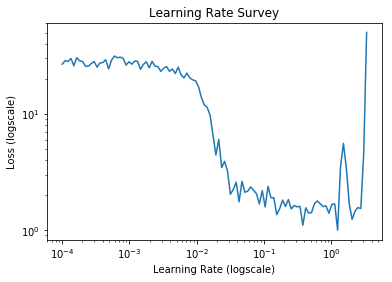

In [11]:
monitor = t.survey_learning_rate(min_learning_rate=1e-4, max_learning_rate=10, num_epochs=2, stop_factor=10)
monitor.dataframe_monitor.plot_learning_rate_survey()

In [12]:
from sconce.schedules import Triangle
t.model.set_schedule('learning_rate', Triangle(initial_value=1e-3, peak_value=1e-1, peak_fraction=0.33))
t.model.set_schedule('momentum', Triangle(initial_value=0.8, peak_value=0.1, peak_fraction=0.33))
t.train(num_epochs=2)

117/117 [==============================] - 25s 211ms/step - loss: 1.5876 - val_loss: 1.5329


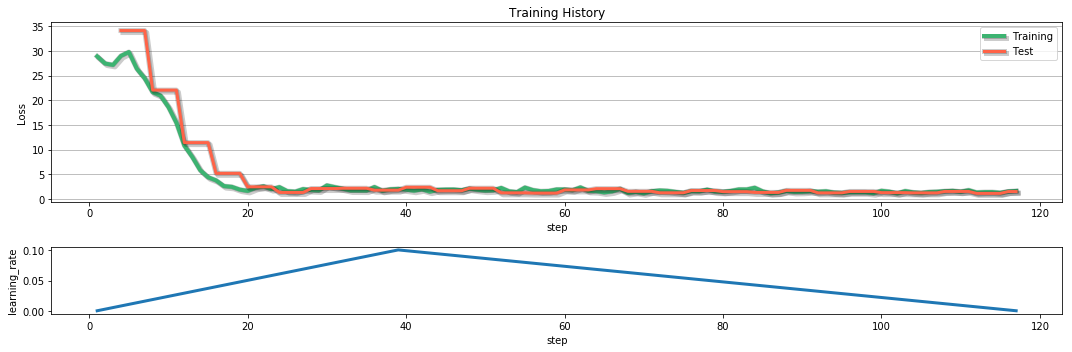

In [13]:
t.monitor.dataframe_monitor.plot(skip_first=0, smooth_window=1);

In [14]:
unfreeze(t)

layer_factors = dict(ve=1.0, layer4=0.5, layer3=0.1, layer2=0.01, layer1=0.001)

for name, factor in layer_factors.items():
    group = t.model.get_parameter_group(name)
    group.set_schedule('learning_rate', Triangle(initial_value=1e-3 * factor,
                                                 peak_value=1e-1 * factor,
                                                 peak_fraction=0.33))
    group.set_schedule('momentum', Triangle(initial_value=0.95,
                                            peak_value=0.3,
                                            peak_fraction=0.33))

t.train(num_epochs=2)

117/117 [==============================] - 63s 538ms/step - loss: 0.7486 - val_loss: 0.8792


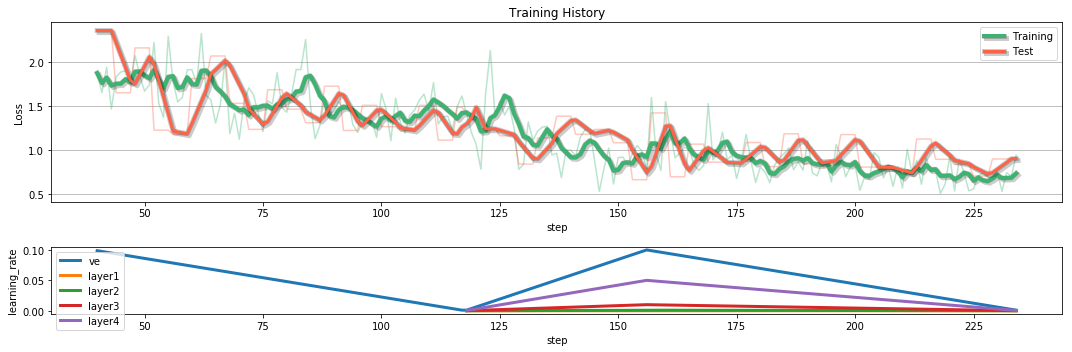

In [15]:
t.monitor.dataframe_monitor.plot(skip_first=40, smooth_window=5);

In [16]:
def run_model_on_feed(trainer, feed):
    inputs = []
    targets = []
    outputs = []
    value_grids = []

    feed.reset()
    for x in range(len(feed)):
        i, t = feed.next()
        out_dict = trainer._run_model(i, t, train=False)

        inputs.append(i.cpu().data.numpy())
        targets.append(t.cpu().data.numpy())
        outputs.append(out_dict['outputs'].cpu().data.numpy())
        value_grids.append(out_dict['value_grid'].cpu().data.numpy())

    inputs = np.concatenate(inputs)
    targets = np.concatenate(targets)
    outputs = np.concatenate(outputs)
    value_grids = np.concatenate(value_grids)
    
    outputs = outputs.squeeze()
    value_grids.squeeze()
    
    real_targets = np.expm1(targets).astype(np.int32)
    real_outputs = np.expm1(outputs).astype(np.int32)

    return {'inputs': inputs,
            'targets': targets,
            'outputs': outputs,
            'real_targets': real_targets,
            'real_outputs': real_outputs,
            'value_grids': value_grids}


In [17]:
run_dict = run_model_on_feed(t, t.validation_feed)

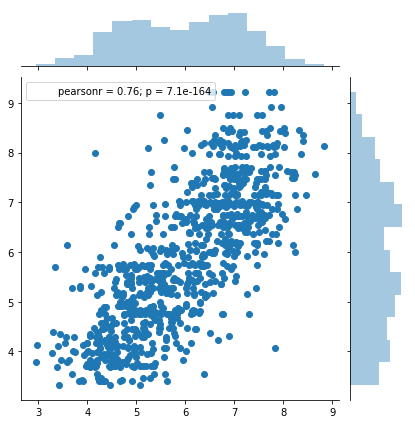

In [18]:
import seaborn as sbn
sbn.jointplot(run_dict['outputs'], run_dict['targets'])

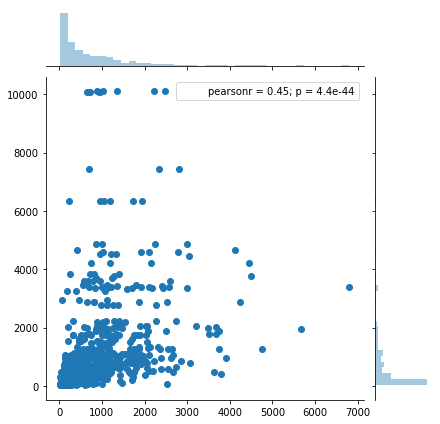

In [19]:
sbn.jointplot(run_dict['real_outputs'], run_dict['real_targets'])

In [25]:
training_run_dict = run_model_on_feed(t, t.training_feed)

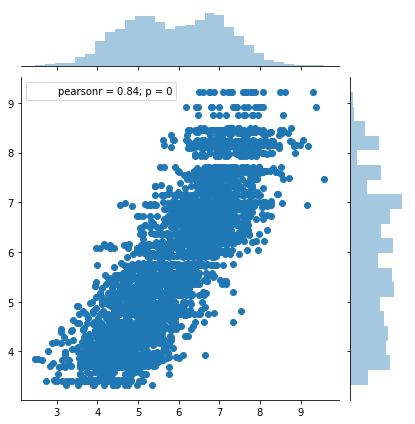

In [26]:
sbn.jointplot(training_run_dict['outputs'], training_run_dict['targets'])

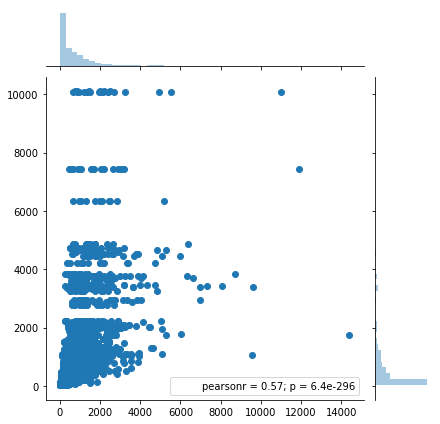

In [27]:
sbn.jointplot(training_run_dict['real_outputs'], training_run_dict['real_targets'])


In [34]:
from matplotlib import pyplot as plt
import scipy

def plot_heatmap(index=0):
    target    = run_dict['real_targets'][index]
    predicted = run_dict['real_outputs'][index]
    print("Showing image of target value: %s" % target)
    print("              predicted value: %s" % predicted)
    
    input_image = run_dict['inputs'][index]
    input_image = input_image.swapaxes(0, 2)
    input_image = input_image.swapaxes(0, 1)
    fig = plt.figure(figsize=(13, 7))
    ax = fig.add_subplot(1, 3, 1)
    common_ax = fig.add_subplot(1, 3, 3)
    
    ax.imshow(input_image)
    common_ax.imshow(input_image)

    grid = run_dict['value_grids'][index]
    grid -= grid.min()
    grid /= grid.max()
    grid = grid.squeeze()
    upsampled_grid = scipy.misc.imresize(grid, input_image.shape, interp='nearest')
    
    ax = fig.add_subplot(1, 3, 2)
    plt.sca(ax)
    plt.imshow(upsampled_grid, cmap='hot_r')
    common_ax.imshow(upsampled_grid, alpha=0.4, cmap='hot_r')
    
    plt.colorbar(ax=common_ax)

In [35]:
from ipywidgets import interact, Layout
import ipywidgets as widgets

interact(plot_heatmap, index=widgets.IntText(0));

interactive(children=(IntText(value=0, description='index'), Output()), _dom_classes=('widget-interact',))